# Nonlinear PCA Tutorial
Motivating the use of guided variational autoencoders (GVAEs) for semantic segmentation of labelled factors of variation in the data 🚀

In [1]:
from proteovae.models import GuidedVAE, GuidedConfig
import proteovae.models.base as base 
import numpy as np 
import matplotlib.pyplot as plt 

Generate samples artificially coming from homoschedastic gaussian distributions with different means

Text(0.5, 1.0, 'sample data')

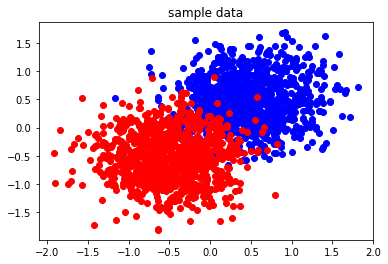

In [34]:
nsamples = 1000

m1 = (0.5,0.5)
m2 = (-0.5,-0.5)
cov1 = 0.2*np.eye(2)
cov2 = cov1

g1 = np.random.multivariate_normal(m1, cov = cov2, size = nsamples)
g2 = np.random.multivariate_normal(m2, cov = cov2, size = nsamples)

X_ = np.concatenate((g1,g2),axis=0)
Y_ = np.zeros(2*nsamples)
Y_[nsamples:] = np.ones(nsamples)


#visualize
plt.scatter(*g1.T, color='blue')
plt.scatter(*g2.T, color='red')
plt.title('sample data')

## creating data loaders 

In [12]:
from torch.utils.data import Dataset 
from torch.utils.data import DataLoader
import torch 

# custom torch datasets need to provide __len__ and __getitem__ methods 
class TorchDataset():
    def __init__(self, data, labels):
        self.data = torch.Tensor(data)
        self.labels = torch.Tensor(labels)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx],  self.labels[idx]

In [13]:
from sklearn.model_selection import train_test_split

batch_size = 32
test_size = 0.2

#train-test-validation splits 
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X_,Y_, test_size=test_size)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val,Y_train_val, test_size=test_size)

#data loaders 
train_data = TorchDataset(X_train, Y_train) 
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)

val_data = TorchDataset(X_val, Y_val) 
val_data = (val_data.data, val_data.labels)

#printing labels for a batch 
print(next(iter(train_loader))[1])

tensor([0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1.])


## model init
The form of the objective function for the GVAE includes **two** additional terms with respect to the standard VAE ELBO

$
\begin{align}
            \mathcal{L}(\boldsymbol{\theta}, \boldsymbol{\phi}; x) &= \mathbb{E}_{z \sim q_{\boldsymbol{\phi}}(z|x)}\left[\log p_{\boldsymbol{\theta}}(x|z)\right] - 
                \beta D_{KL}(q_{\boldsymbol{\phi}}(z|x)||p_{\boldsymbol{\theta}}(z)) - \eta H(Y, \psi(\bar{Z}))- \left(\gamma_{od}\sum_{i\neq j}||[Cov(z)]_{i,j}|| + \gamma_{d}\sum_{i=1}^{d}||[Cov(z)]_{ii}-1||\right)
            \end{align} 
$

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# declare a model configuration 
model_config = GuidedConfig(
    input_dim = 2,
    latent_dim = 2,
    device = device,
    guided_dim = 1,
    eta = 30*(1e-02),
    gamma = 30*(1e-02),
    beta = 1*(1e-02),
)

# misc 
encoder_hidden_dims = (16,) 
decoder_hidden_dims = encoder_hidden_dims[::-1]
n_classes = 2

# model init 
model = GuidedVAE(
    config = model_config,
    encoder = base.Encoder(model_config.input_dim, model_config.latent_dim, encoder_hidden_dims), 
    decoder = base.Decoder(model_config.input_dim, model_config.latent_dim, decoder_hidden_dims),
    guide = base.Guide(model_config.guided_dim, n_classes),
)

model

GuidedVAE(
  (encoder): Encoder(
    (linear_block): Sequential(
      (0): Linear(in_features=2, out_features=16, bias=True)
      (1): ReLU()
    )
    (fc_mu): Linear(in_features=16, out_features=2, bias=True)
    (fc_logvar): Linear(in_features=16, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (linear_block): Sequential(
      (0): Linear(in_features=2, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=2, bias=True)
    )
  )
  (guide): Guide(
    (classifier): Sequential(
      (0): Linear(in_features=1, out_features=2, bias=True)
    )
  )
)

## Training

In [38]:
from proteovae.trainers import ScheduledTrainer

# torch optimzers and schedulers 
optimizer = torch.optim.Adam(model.parameters(), lr=5e-03)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda e: max(0.98**(e), 5e-04), last_epoch=- 1)

# trainer init 
trainer = ScheduledTrainer(model, optimizer, scheduler)

In [39]:
# training
trainer.train(train_loader, epochs=100, val_data = val_data)

Epoch [1/100]
lr=5.00e-03
loss: 0.882361 | recon: 0.729138 | kl: 0.218907 | dipvae: 0.040955 | acc: 0.968750
val_acc: 0.906250


Epoch [2/100]
lr=4.90e-03
loss: 0.594225 | recon: 0.483303 | kl: 0.635193 | dipvae: 0.041612 | acc: 0.937500
val_acc: 0.928125


Epoch [3/100]
lr=4.80e-03
loss: 0.412311 | recon: 0.317614 | kl: 1.055168 | dipvae: 0.055751 | acc: 0.937500
val_acc: 0.909375


Epoch [4/100]
lr=4.71e-03
loss: 0.356767 | recon: 0.268628 | kl: 1.248982 | dipvae: 0.057117 | acc: 0.937500
val_acc: 0.909375


Epoch [5/100]
lr=4.61e-03
loss: 0.342884 | recon: 0.261760 | kl: 1.386843 | dipvae: 0.045723 | acc: 0.937500
val_acc: 0.915625


Epoch [6/100]
lr=4.52e-03
loss: 0.274016 | recon: 0.196273 | kl: 1.585068 | dipvae: 0.036262 | acc: 0.937500
val_acc: 0.912500


Epoch [7/100]
lr=4.43e-03
loss: 0.250962 | recon: 0.170291 | kl: 1.761590 | dipvae: 0.046774 | acc: 0.937500
val_acc: 0.909375


Epoch [8/100]
lr=4.34e-03
loss: 0.236232 | recon: 0.152722 | kl: 1.911493 | dipvae: 0.055133 | ac

{'loss': [tensor(0.8824),
  tensor(0.5942),
  tensor(0.4123),
  tensor(0.3568),
  tensor(0.3429),
  tensor(0.2740),
  tensor(0.2510),
  tensor(0.2362),
  tensor(0.2187),
  tensor(0.1959),
  tensor(0.2025),
  tensor(0.2062),
  tensor(0.2179),
  tensor(0.1910),
  tensor(0.1654),
  tensor(0.2026),
  tensor(0.2138),
  tensor(0.1790),
  tensor(0.1916),
  tensor(0.1638),
  tensor(0.1814),
  tensor(0.1659),
  tensor(0.1623),
  tensor(0.1595),
  tensor(0.1705),
  tensor(0.1728),
  tensor(0.1972),
  tensor(0.1795),
  tensor(0.1797),
  tensor(0.1868),
  tensor(0.1655),
  tensor(0.1719),
  tensor(0.1578),
  tensor(0.1756),
  tensor(0.2017),
  tensor(0.2241),
  tensor(0.1744),
  tensor(0.1501),
  tensor(0.1694),
  tensor(0.1822),
  tensor(0.1738),
  tensor(0.1567),
  tensor(0.1798),
  tensor(0.1800),
  tensor(0.1491),
  tensor(0.1937),
  tensor(0.1521),
  tensor(0.1622),
  tensor(0.1659),
  tensor(0.1979),
  tensor(0.1524),
  tensor(0.1850),
  tensor(0.1445),
  tensor(0.1482),
  tensor(0.1511),
  

## investigating the embedding space 

*note: future versions of the `proteovae` package will implement a model.embed() method to simplify this procedure!*

In [40]:
#test data 
X, y = X_test, Y_test

# encode with model.encoder object 
embs = model.embed(torch.tensor(X, device = device, dtype=torch.float32))

The next part may look a little strange but here's what's happening &#x1F4A1; &#x1F447; :
* first make a copy of the embeddings for our test samples
* we hard set the dimension in these embeddings which was attached to the classification branch during training to a fixed value
* original and modified embeddings are decoded using the model decoder 

/var/folders/km/gzpvwhgs1wzdtjck5sp3b5lm0000gn/T/ipykernel_53400/335800380.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_decoded = model.decoder(torch.tensor(embs, device=device))


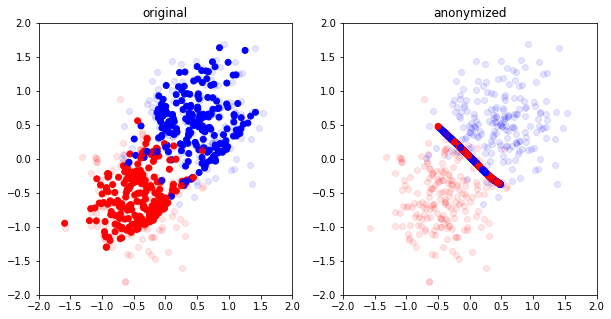

In [41]:
from copy import deepcopy 
anonymous_embs = deepcopy(embs.numpy())

# hard set the guided dimension before decoding 
anonymous_embs[:,-model.guided_dim:] = np.mean(np.zeros(model.guided_dim))

# decode the original and anonymized embeddings 
pca = model.decoder(torch.tensor(anonymous_embs, device=device))
pca = pca.cpu().detach().numpy()

ref_decoded = model.decoder(torch.tensor(embs, device=device))
ref_decoded = ref_decoded.cpu().detach().numpy()

fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].scatter(*ref_decoded.T, color = ['red' if i==1 else 'blue' for i in Y_test])
axs[0].set_xlim(-2,2)
axs[0].set_ylim(-2,2)
axs[0].set_title('original')
axs[0].scatter(*X_test[Y_test==1].T, color = (1., 0., 0., 0.1))
axs[0].scatter(*X_test[Y_test==0].T, color = (0., 0., 1., 0.1))

axs[1].scatter(*pca.T, color = ['red' if i==1 else 'blue' for i in Y_test])
axs[1].set_xlim(-2,2)
axs[1].set_ylim(-2,2)
axs[1].set_title('anonymized')
axs[1].scatter(*X_test[Y_test==1].T, color = (1., 0., 0., 0.1))
axs[1].scatter(*X_test[Y_test==0].T, color = (0., 0., 1., 0.1))


#plt.scatter(*X_test.T)

And there you have it 😋! The results above are a verrryyy roundabout way to achieving what is essentially projection of the data on one of the principle axes, but the strategy illustrates that you can a) control the shape your embeddings take, and b) anonymize your reconstructions by removing discriminative features

# PCA application 3d 

In [2]:
from sklearn.decomposition import PCA 

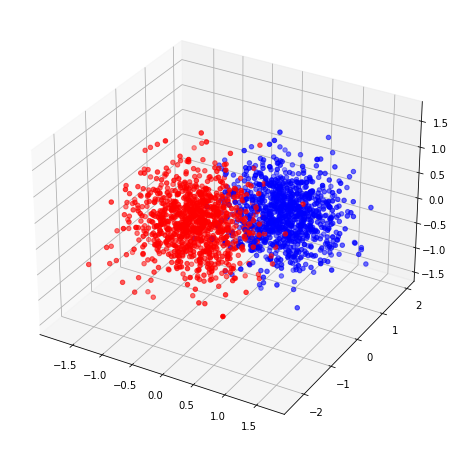

In [43]:
nsamples = 1000

m1 = (0.5,0.5,0)
m2 = (-0.5,-0.5,0)
cov1 = 0.2*np.eye(3)
cov2 = cov1

g1 = np.random.multivariate_normal(m1, cov = cov2, size = nsamples)
g2 = np.random.multivariate_normal(m2, cov = cov2, size = nsamples)

X_ = np.concatenate((g1,g2),axis=0)
Y_ = np.zeros(2*nsamples)
Y_[nsamples:] = np.ones(nsamples)


#visualize
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_[:,0], X_[:,1], X_[:,2], c=[(1,0,0) if i == 1 else (0,0,1) for i in Y_])
plt.show()

In [14]:
batch_size = 32
test_size = 0.2

#train-test-validation splits 
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X_,Y_, test_size=test_size)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val,Y_train_val, test_size=test_size)

#data loaders 
train_data = TorchDataset(X_train, Y_train) 
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)

val_data = TorchDataset(X_val, Y_val) 
val_data = (val_data.data, val_data.labels)

#printing labels for a batch 
print(next(iter(train_loader))[1])

tensor([1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
        1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.])


In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# declare a model configuration 
model_config = GuidedConfig(
    input_dim = 3,
    latent_dim = 3,
    device = device,
    guided_dim = 1,
    eta = 30*(1e-02),
    gamma = 30*(1e-02),
    beta = 1*(1e-02),
)

# misc 
encoder_hidden_dims = (16,) 
decoder_hidden_dims = encoder_hidden_dims[::-1]
n_classes = 2

# model init 
model = GuidedVAE(
    config = model_config,
    encoder = base.Encoder(model_config.input_dim, model_config.latent_dim, encoder_hidden_dims), 
    decoder = base.Decoder(model_config.input_dim, model_config.latent_dim, decoder_hidden_dims),
    guide = base.Guide(model_config.guided_dim, n_classes),
)

model

GuidedVAE(
  (encoder): Encoder(
    (linear_block): Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): ReLU()
    )
    (fc_mu): Linear(in_features=16, out_features=3, bias=True)
    (fc_logvar): Linear(in_features=16, out_features=3, bias=True)
  )
  (decoder): Decoder(
    (linear_block): Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=3, bias=True)
    )
  )
  (guide): Guide(
    (classifier): Sequential(
      (0): Linear(in_features=1, out_features=2, bias=True)
    )
  )
)

In [34]:
# torch optimzers and schedulers 
optimizer = torch.optim.Adam(model.parameters(), lr=5e-03)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda e: max(0.98**(e), 5e-04), last_epoch=- 1)

# trainer init 
trainer = ScheduledTrainer(model, optimizer, scheduler)

In [35]:
# training
trainer.train(train_loader, epochs=100, val_data = val_data)

Epoch [1/100]
lr=5.00e-03
loss: 1.019192 | recon: 0.817691 | kl: 0.243954 | dipvae: 0.079174 | acc: 0.906250
val_acc: 0.843750


Epoch [2/100]
lr=4.90e-03
loss: 1.003803 | recon: 0.777693 | kl: 0.676286 | dipvae: 0.322709 | acc: 0.937500
val_acc: 0.956250


Epoch [3/100]
lr=4.80e-03
loss: 0.866697 | recon: 0.656087 | kl: 0.894739 | dipvae: 0.368901 | acc: 0.968750
val_acc: 0.962500


Epoch [4/100]
lr=4.71e-03
loss: 0.778971 | recon: 0.620928 | kl: 1.098556 | dipvae: 0.255653 | acc: 0.968750
val_acc: 0.959375


Epoch [5/100]
lr=4.61e-03
loss: 0.586801 | recon: 0.481273 | kl: 1.419363 | dipvae: 0.118669 | acc: 0.968750
val_acc: 0.959375


Epoch [6/100]
lr=4.52e-03
loss: 0.497521 | recon: 0.404568 | kl: 1.747409 | dipvae: 0.091792 | acc: 0.968750
val_acc: 0.962500


Epoch [7/100]
lr=4.43e-03
loss: 0.439279 | recon: 0.352893 | kl: 1.931731 | dipvae: 0.078846 | acc: 0.968750
val_acc: 0.962500


Epoch [8/100]
lr=4.34e-03
loss: 0.427137 | recon: 0.339956 | kl: 2.041105 | dipvae: 0.090123 | ac

{'loss': [tensor(1.0192),
  tensor(1.0038),
  tensor(0.8667),
  tensor(0.7790),
  tensor(0.5868),
  tensor(0.4975),
  tensor(0.4393),
  tensor(0.4271),
  tensor(0.3962),
  tensor(0.4437),
  tensor(0.4205),
  tensor(0.3945),
  tensor(0.3872),
  tensor(0.3697),
  tensor(0.4032),
  tensor(0.3447),
  tensor(0.3430),
  tensor(0.4051),
  tensor(0.3567),
  tensor(0.3501),
  tensor(0.3767),
  tensor(0.3702),
  tensor(0.3921),
  tensor(0.3208),
  tensor(0.3492),
  tensor(0.2993),
  tensor(0.3154),
  tensor(0.3205),
  tensor(0.3017),
  tensor(0.2953),
  tensor(0.3066),
  tensor(0.2906),
  tensor(0.2768),
  tensor(0.3081),
  tensor(0.2709),
  tensor(0.2638),
  tensor(0.2498),
  tensor(0.2804),
  tensor(0.2810),
  tensor(0.2859),
  tensor(0.2772),
  tensor(0.3044),
  tensor(0.2519),
  tensor(0.2687),
  tensor(0.2256),
  tensor(0.2511),
  tensor(0.2179),
  tensor(0.2418),
  tensor(0.2652),
  tensor(0.2084),
  tensor(0.2437),
  tensor(0.2545),
  tensor(0.2576),
  tensor(0.2615),
  tensor(0.2102),
  

In [36]:
#test data 
X, y = X_test, Y_test

# encode with model.encoder object 
embs = model.embed(torch.tensor(X, device = device, dtype=torch.float32))

/var/folders/km/gzpvwhgs1wzdtjck5sp3b5lm0000gn/T/ipykernel_54564/3624675603.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_decoded = model.decoder(torch.tensor(embs, device=device))
/Users/nathanielnethercott/opt/miniconda3/envs/massi/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:985: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asarray(x)


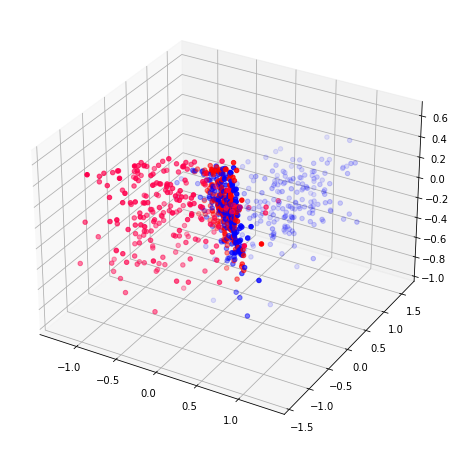

In [44]:
from copy import deepcopy 
anonymous_embs = deepcopy(embs.numpy())

# hard set the guided dimension before decoding 
anonymous_embs[:,-model.guided_dim:] = np.mean(np.zeros(model.guided_dim))

# decode the original and anonymized embeddings 
pca = model.decoder(torch.tensor(anonymous_embs, device=device))
pca = pca.cpu().detach().numpy()

ref_decoded = model.decoder(torch.tensor(embs, device=device))
ref_decoded = ref_decoded.cpu().detach().numpy()

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection='3d')

ax.scatter3D(pca[:,0], pca[:,1], pca[:,2], c = [(1,0,0) if i == 1 else (0,0,1) for i in Y_test])
ax.scatter3D(ref_decoded[:,0], ref_decoded[:,1], ref_decoded[:,2], c = [(1,0,0.3) if i == 1 else (0,0,1,0.3) for i in Y_test])